# A simple SMC setup

We setup the dna->aa fst and a dummy bigram model

In [49]:
from transduction import FST, EPSILON, Precover

In [50]:
from transduction.smc.aa import score_sequence, create_dna_translator, AA, get_source_lm_probs, BIGRAM_PROBS

In [51]:
fst = create_dna_translator()
input_dna = "ATGCCTTAA" 
result = fst(input_dna, None)
display(result)

In [52]:
seq = "ACGT"
log_score = score_sequence(seq, log_space=True)
print(f"Log probability of {seq}: {log_score:.4f}")
raw_score = score_sequence(seq, log_space=False)
print(f"Raw Probability of {seq}:   {raw_score:.6f}")

Log probability of ACGT: -6.9078
Raw Probability of ACGT:   0.001000


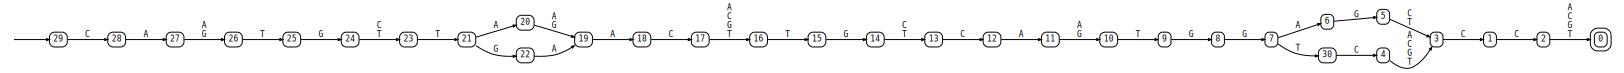

Size:  4608


In [53]:
seq = "QC*TCQWSP"
pc = Precover(fst, seq)
q, r = pc.decomposition
display(q)
assert len(q.states) != 0
display(r)
lang = list(q.language(100))
print("Size: ", len(lang))

### Exact probabilities 

for getting the baselines to compare SMC against

In [54]:
import math

def logsumexp(log_probs):
   
    if not log_probs:
        return float('-inf')
    
    max_score = max(log_probs)
    if max_score == float('-inf'):
        return float('-inf')
        
    return max_score + math.log(sum(math.exp(x - max_score) for x in log_probs))

def score(seq, fst, max_length=100000):
    pc = Precover(fst, seq)
    q, r = pc.decomposition
    contributions = []
    for seq in q.language(max_length=max_length):
        contributions.append(score_sequence(seq, log_space=True) )
        
    total_log_prob = logsumexp(contributions)
    return total_log_prob

def logp_next(seq, fst, vocabulary):
    unnormalized_log_probs = {}
    
    for token in vocabulary:
        next_seq = seq + token
        unnormalized_log_probs[token] = score(next_seq, fst)
    
    log_probs_list = list(unnormalized_log_probs.values())
    log_Z = logsumexp(log_probs_list)
    normalized_dist = {}
    
    for token, log_prob in unnormalized_log_probs.items():
        if log_prob == float('-inf'):
            normalized_dist[token] = float('-inf')
        else:
            normalized_dist[token] = log_prob - log_Z
            
    return normalized_dist

In [55]:
score(seq, fst)

-30.551571423295506

In [56]:
dist = logp_next(seq, fst, AA)

logsumexp(dist.values())

2.220446049250313e-16

### SMC helpers

In [57]:
from transduction.smc.base import extend_output, is_compatible, compute_epsilon_closure, Particle, transition_frontier, StateTuple
from transduction import EPSILON, FST

In [58]:
assert extend_output("a", "b") == "ab"
assert extend_output("a", EPSILON) == "a"
assert is_compatible("ab","a")
assert is_compatible("a", "ab")
assert not is_compatible("ac", "ab")
assert not is_compatible("ab", "ac")

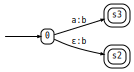

In [59]:
m = FST()
start_node = 0
m.add_I(start_node)
m.add_arc(start_node, EPSILON, "b", "s2")
m.add_F("s2")
m.add_arc(start_node, "a", "b", "s3")
m.add_F("s3")
display(m)

In [60]:
start = list((s, "") for s in m.I)
compute_epsilon_closure(start, m, target_y="bc")

{('s2', 'b'), (0, '')}

In [61]:
print(score_sequence("AGT"))
x1 = get_source_lm_probs("", BIGRAM_PROBS.keys())["A"]
x2 = get_source_lm_probs("A", BIGRAM_PROBS.keys())["G"]
x3 = get_source_lm_probs("AG", BIGRAM_PROBS.keys())["T"]
print(x1+x2+x3)

-4.199705077879927
-4.199705077879927


In [62]:
start = Particle.initial(fst.I, fst, "QQ").states
front = transition_frontier(start, fst, "G", "QQ")


In [ ]:
from transduction.smc.base import check_universality, next_power_state, can_extend_power_state
from typing import FrozenSet, Dict, Set, Tuple, FrozenSet, List


In [65]:
def get_constrained_proposal(
    p: Particle, 
    fst: 'FST', 
    raw_lm_log_probs: Dict[str, float], 
    target_y: str
) -> Tuple[Dict[str, float], float]:
    """
    Implements Equation 9: q(x) propto p(x) * Indicator(x in A(S)).
    Returns:
        proposal_dist: Normalized log-probs of valid tokens.
        log_Z: The normalization constant (sum of valid raw masses).
    """
    valid_dist = {}
    valid_log_probs = []
    
    # 1. Filter: Keep only tokens that keep the FST compatible (Indicator function)
    for token, log_p in raw_lm_log_probs.items():
        if log_p == float('-inf'): 
            continue
            
        if can_extend_power_state(p.states, fst, token, target_y):
            valid_dist[token] = log_p
            valid_log_probs.append(log_p)
            
    if not valid_dist:
        return {}, float('-inf') # Dead end
        
    # 2. Renormalize: Calculate Z (Sum of valid raw masses)
    log_Z = logsumexp(valid_log_probs)
    
    # 3. Construct q(x) = p(x) / Z
    proposal_dist = {
        t: lp - log_Z 
        for t, lp in valid_dist.items()
    }
    
    return proposal_dist, log_Z

In [ ]:
import random
import math
from typing import List, Dict 


def smc_step(
    particles: List[Particle], 
    fst: 'FST', 
    lm_log_probs: Dict[str, float], 
    target_y: str
) -> List[Particle]:
    
    new_particles = []

    for p in particles:

        # TODO: CONFIRM THIS LOGIC

        if p.is_universal or p.is_complete:
            new_particles.append(p)
            continue

        valid_tokens = get_valid_proposal_tokens(p, fst, target_y)
        if not valid_tokens:
            # weight 0
            continue
        
        valid_log_probs = []
        for t in valid_tokens:
            lp = lm_log_probs.get(t, float('-inf'))
            valid_log_probs.append(lp)
            
        log_Z = logsumexp(valid_log_probs)
        if log_Z == float('-inf'):
            continue

        new_weight = p.weight + log_Z

        # q(x) \propto P_LM(x) * Indicator{x in A(S)}
        sampled_token = sample_from_log_probs(valid_tokens, valid_log_probs, log_Z)
        
        new_states, is_univ, is_done = next_power_state(p.states, fst, sampled_token, target_y)
        
        new_p = Particle(
            x=p.x + (sampled_token,),
            states=new_states,
            weight=new_weight,
            is_universal=is_univ,
            is_complete=is_done
        )
        new_particles.append(new_p)

    return new_particles



def get_valid_proposal_tokens(p: Particle, fst: 'FST', target_y: str) -> List[str]:
    """
    identifies A(S), the set of source tokens that allow the FST to 
    remain compatible with target_y.

    We take the epsilon output closure to ensure we dont allow all epsilons
    """
    valid = []
    
    for token in fst.A: 
        if can_extend_power_state(p.states, fst, token, target_y):
            valid.append(token)
            
    return valid


def sample_from_log_probs(tokens: List[str], log_probs: List[float], log_Z: float) -> str:
    """Samples a token proportional to exp(log_prob)."""
    # Standard categorical sampling in log-space
    # Threshold r ~ Uniform(0, Z) => log(r) ~ log(Uniform(0, 1)) + log(Z)
    r = math.log(random.random()) + log_Z
    
    cumulative = float('-inf')
    for t, lp in zip(tokens, log_probs):
        cumulative = logsumexp([cumulative, lp])
        if r < cumulative:
            return t
    
    return tokens[-1] # Fallback for floating point errors

In [67]:
def smc_step_constrained(
    particles: List[Particle], 
    fst: 'FST', 
    vocab: List[str],
    target_y: str
) -> List[Particle]:
    
    new_particles = []

    for p in particles:
        # Case A: Complete (Remainder) -> Freeze
        # These paths exactly matched target_y and stopped. 
        # They cannot extend without breaking the exact match.
        if p.is_complete:
            new_particles.append(p)
            continue

        # 1. Get Raw LM Distribution p(x)
        seq_str = "".join(p.x)
        raw_lm_dist = get_source_lm_probs(seq_str, vocab)

        # Case B: Universal (Quotient) -> Regime Switch
        # The FST accepts everything from here. 
        # We sample from the raw LM without constraints.
        if p.is_universal:
            # Proposal = Raw LM (normalized)
            # Z = 1.0 (log Z = 0.0) because we sum over entire vocab
            proposal_dist = raw_lm_dist 
            log_Z = 0.0 
            
            # Sample next token
            tokens = list(proposal_dist.keys())
            probs = list(proposal_dist.values())
            sampled_token = sample_from_log_probs(tokens, probs, log_Z=0.0)
            
            new_weight = p.weight + log_Z # Adds 0.0, weight stays constant
            
            # State remains Universal (no need to update FST state)
            new_particles.append(Particle(
                x=p.x + (sampled_token,),
                states=p.states,
                weight=new_weight,
                is_universal=True,
                is_complete=False
            ))
            continue

        # Case C: Active (Constraint Checking)
        # 2. Compute Proposal q(x) and Weight Update Z
        proposal_dist, log_Z = get_constrained_proposal(p, fst, raw_lm_dist, target_y)
        
        if not proposal_dist:
            continue # Dead end

        # 3. Sample x ~ q(x)
        tokens = list(proposal_dist.keys())
        probs = list(proposal_dist.values())
        sampled_token = sample_from_log_probs(tokens, probs, log_Z=0.0)
        
        # 4. Update Weight: w_t = w_{t-1} + log(Z)
        new_weight = p.weight + log_Z
        
        # 5. Transition
        new_states, is_univ, is_done = next_power_state(p.states, fst, sampled_token, target_y)
        
        new_particles.append(Particle(
            x=p.x + (sampled_token,),
            states=new_states,
            weight=new_weight,
            is_universal=is_univ,
            is_complete=is_done
        ))

    return new_particles

In [68]:
def heuristic_shaping(states: FrozenSet[StateTuple], target_y: str) -> float:
    """
    Approximates psi(y) = Probability that these states can complete target_y.
    Heuristic: Fraction of states in the frontier that are currently compatible.
    """
    if not states:
        return 0.0
    
    # Count states that are compatible prefixes of target_y
    compatible_count = sum(1 for s, ys in states if is_compatible(ys, target_y))
    total = len(states)
    
    # Return ratio. We use a small epsilon to avoid log(0) if something valid exists
    # but the heuristic misses it (though in your logic, incompatible states are pruned).
    return compatible_count / total if total > 0 else 0.0

In [ ]:
import random
import math
from typing import List


In [70]:
def smc_step_twisted(
    particles: List[Particle], 
    fst: 'FST', 
    vocab: List[str],
    target_y: str
) -> List[Particle]:
    
    new_particles = []

    for p in particles:
        if p.is_universal or p.is_complete:
            new_particles.append(p)
            continue

        # 1. Calculate Current Shaping Value psi(y_{t-1})
        psi_current = heuristic_shaping(p.states, target_y)
        
        # If psi is 0, this particle is dead (should have been pruned earlier)
        if psi_current <= 1e-9:
            continue

        # 2. Get Raw LM Distribution
        seq_str = "".join(p.x)
        raw_lm_dist = get_source_lm_probs(seq_str, vocab)
        
        # 3. Compute Proposal and Z
        # This implicitly uses the "Binary" lookahead to filter tokens
        proposal_dist, log_Z = get_constrained_proposal(p, fst, raw_lm_dist, target_y)
        
        if not proposal_dist:
            continue 

        # 4. Sample
        tokens = list(proposal_dist.keys())
        probs = list(proposal_dist.values())
        sampled_token = sample_from_log_probs(tokens, probs, log_Z=0.0)
        
        # 5. Transition
        new_states, is_univ, is_done = next_power_state(p.states, fst, sampled_token, target_y)
        
        # 6. Calculate Future Shaping Value psi(y_t)
        # Note: If complete or universal, potential is max (1.0)
        if is_done or is_univ:
            psi_future = 1.0
        else:
            psi_future = heuristic_shaping(new_states, target_y)
            
        if psi_future <= 1e-9:
            continue # Dead end despite lookahead (rare, but possible with epsilon chains)

        # 7. Update Weight with Shaping Ratio
        # w_new = w_old * Z * (psi_new / psi_old)
        # log(w) = log(w) + log_Z + log(psi_new) - log(psi_old)
        log_shaping_ratio = math.log(psi_future) - math.log(psi_current)
        new_weight = p.weight + log_Z + log_shaping_ratio
        
        new_particles.append(Particle(
            x=p.x + (sampled_token,),
            states=new_states,
            weight=new_weight,
            is_universal=is_univ,
            is_complete=is_done
        ))

    return new_particles

In [71]:
def run_smc(
    fst: 'FST',
    target_y: str,
    vocab: List[str],
    num_particles: int = 100,
    max_steps: int = 50,
    resample_threshold: float = 0.5
) -> List[Particle]:
    
    raw_frontier = set((s, "") for s in fst.I)
    initial_frontier = frozenset(compute_epsilon_closure(raw_frontier, fst, target_y))
    
    # 3. Initial Shaping Weight
    # w_0 = log(1.0) + log(psi_init)
    psi_init = heuristic_shaping(initial_frontier, target_y)
    if psi_init <= 1e-9:
        print("Error: Initial state has 0 potential for target.")
        return []
        
    start_weight = math.log(psi_init)
    
    start_p = Particle(x=(), states=initial_frontier, weight=start_weight)
    particles = [start_p for _ in range(num_particles)]
    
    for t in range(max_steps):
        if not particles:
            print(f"All particles died at step {t}")
            break
            
        if all(p.is_universal or p.is_complete for p in particles):
            break
            
        # Use Twisted Step
        particles = smc_step_twisted(particles, fst, vocab, target_y)
        
        # Resample
        particles = resample_particles(particles, resample_threshold)
        
    return particles

In [72]:
def get_decomposed_precover(
    fst: 'FST', 
    target_y: str, 
    vocab: List[str],
    n_particles: int = 100
):
    """
    Runs SMC to approximate the Precover decomposition.
    Returns (quotient_particles, remainder_particles).
    """
    final_particles = run_smc(
        fst, 
        target_y, 
        vocab, 
        num_particles=n_particles
    )
    
    quotient = []
    remainder = []
    
    for p in final_particles:
        if p.is_universal:
            quotient.append(p)
        elif p.is_complete:
            # "Complete" means it hit a Final state and covered the target.
            # This belongs to the Remainder (valid paths that are not universal).
            remainder.append(p)
            
    return quotient, remainder

In [ ]:
# --- Test Config ---
target_seq = "QMQ" # Short target for testing
vocab = list(fst.A)

# Run SMC
q_particles, r_particles = get_decomposed_precover(fst, target_seq, vocab, n_particles=10)

print(f"Target: {target_seq}")
print(f"Quotient Particles: {len(q_particles)}")
print(f"Remainder Particles: {len(r_particles)}")

if q_particles:
    print("\nSample Quotient Particle:")
    print(q_particles)

if r_particles:
    print("\nSample Remainder Particle:")
    print(r_particles[0])

In [ ]:
# --- DEBUGGING TOOL ---
def trace_golden_path(fst, target_protein="M"):
    """
    Manually forces the 'Correct' DNA sequence through your logic
    to find exactly which function is killing the valid path.
    """
    print(f"🔍 Tracing Golden Path for Target: '{target_protein}'")
    
    # 1. Setup Start
    # Use your Particle.initial logic manually
    raw_start = set((s, "") for s in fst.I)
    frontier = frozenset(compute_epsilon_closure(raw_start, fst, target_protein))
    print(f"Step 0 (Start): Frontier size = {len(frontier)}")
    for s, ys in frontier:
        print(f"  - State: {s}, Output: '{ys}'")

    # 2. Define the Golden DNA Sequence for 'M'
    # M = Methionine = ATG
    golden_dna = ['A', 'T', 'G'] * len(target_protein)

    
    current_frontier = frontier
    
    for i, token in enumerate(golden_dna):
        print(f"\n--- Step {i+1}: Applying Token '{token}' ---")
        
        # Test A: Proposal Logic (Lookahead)
        # Does the system think this token is valid?
        is_valid = can_extend_power_state(current_frontier, fst, token, target_protein)
        print(f"1. can_extend_power_state('{token}'): {is_valid}")
        
        if not is_valid:
            print("   ❌ CRITICAL FAILURE: Lookahead rejected the valid token!")
            print("   Investigate 'transition_frontier' or 'is_compatible'.")
            return

        # Test B: Transition Logic (Movement)
        # Actually move the state
        next_frontier = transition_frontier(current_frontier, fst, token, target_protein)
        print(f"2. transition_frontier produced {len(next_frontier)} states")
        
        if not next_frontier:
            print("   ❌ CRITICAL FAILURE: Transition returned empty set!")
            return

        # Inspect the new states
        print("   New States:")
        for s, ys in next_frontier:
            # Check compatibility explicitly
            compat = is_compatible(ys, target_protein)
            print(f"   - State {s}: Output='{ys}' (Len={len(ys)}) | Compatible? {compat}")
            
            # Check for EPSILON artifacts
            if "EPSILON" in ys or "eps" in ys or "None" in ys:
                print("     ⚠️ WARNING: Junk detected in output string!")

        current_frontier = next_frontier

    print("\n✅ SUCCESS: The Golden Path survived all checks.")

# --- RUN IT ---
trace_golden_path(fst, target_protein="MQM")